In [165]:
from __future__ import absolute_import, division, print_function
import os
from scipy.io import loadmat
import arff
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


from sklearn.svm import NuSVC, SVC
from sklearn.svm import libsvm

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

## Feature Paths

In [3]:
FBANK_feat = os.path.join('FBANK','binnedFeat.mat')
FBANK_label = os.path.join('FBANK','binnedLabels.csv')
ComParE_feat = os.path.join('baseline','openSMILEall_PCG.mat')
BOAW_feat = os.path.join('baseline_boaw','feat','boawFeat.4096.arff')
BOAW_meta = os.path.join('baseline_boaw','feat','BOAW_filenames.txt')

In [ ]:
def severe2abnormal(labels):
    for idx,each in enumerate(labels):
        if each == 2:
            labels[idx]=1
    return labels

## Data Loading

In [ ]:
# df = pd.read_csv('/media/taufiq/Data1/heart_sound/heartnet/featGen/mfcc.csv',header=None, delimiter=';')
# df.head()
# with open('/media/taufiq/Data1/heart_sound/heartnet/featGen/BOAW_filenames.txt','w') as fp:
#     for each in df[0].drop_duplicates().values:
#         fp.write("%s\n" % each)

In [85]:
## Load_BOAW:

df = arff.load(open(BOAW_feat,'r'))
boawData = pd.DataFrame(np.array(df['data'],dtype=float))
del df

boawFilenames = []
with open(BOAW_meta, 'r') as fp:
    line = fp.readline()
    boawFilenames.append(line.split('\n')[0])
    while line:
            line = fp.readline()
            boawFilenames.append(line.split('\n')[0])
boawFilenames = boawFilenames[:-1]
boawData['filenames'] = boawFilenames
boawData.rename({4096:'label'},axis='columns',inplace=True)
boawData.label = [int(each) for each in boawData.label]

del boawFilenames
boawData.shape

(3835, 4098)

In [64]:
## Load FBANK: 

df = loadmat(FBANK_feat)
fbankData = pd.DataFrame(df['feats'])
fbankMeta = pd.read_csv(FBANK_label)
fbankMeta.file_name = [each[0] for each in fbankMeta.file_name.str.split('.')]
fbankData = fbankData.join(fbankMeta)
fbankData.dropna(inplace=True)
fbankData.rename({'file_name':'filenames'},axis="columns",inplace=True)
fbankData.label = [int(each) for each in fbankData.label]

del df, fbankMeta

fbankData.shape

(3835, 2709)

In [93]:
## Load ComParE:

df = loadmat(ComParE_feat)

compareData = pd.DataFrame(df['dataTrain'])
compareData = pd.concat((compareData,pd.DataFrame(df['dataDev'])),axis="rows").reset_index(drop=True)
compareData['label'] = np.concatenate((np.hstack(df['TrainLabels']),np.hstack(df['DevLabels'])),axis=0)
compareData['filenames'] = np.concatenate((np.hstack(df['TrainFiles']),np.hstack(df['DevFiles'])),axis=0)
compareData.filenames = [each[0] for each in compareData.filenames.str.split('.')]
compareData.label = [int(each) for each in compareData.label]

del df

compareData.shape

(3835, 6375)

## Under-Sampling

In [62]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [108]:
compareData['dataset'] = [each[-1][0] for each in compareData.filenames.str.split('_')]

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.4714285714285714
0.0


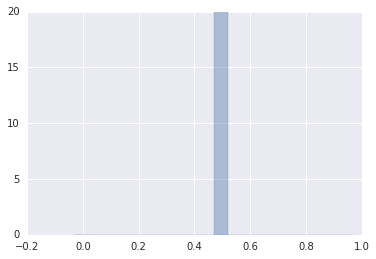

In [180]:
dataset = '0'

np.random.seed(1)
rand_states = np.random.randint(20000,size=(10,))
scaler = StandardScaler()
mask = compareData.dataset == dataset
X_ = scaler.fit_transform(compareData[range(6373)][mask]) ## .4489999
results = []
for rand_state in rand_states:
    rand_state = 144
    rus = RandomUnderSampler(random_state=rand_state)    
    X,y = rus.fit_resample(X_,compareData.label[mask])
    
    clf = NuSVC(kernel='linear',probability=True,verbose=True,
              random_state=rand_state, nu = .3)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                      test_size = 0.2,
                                                      random_state = rand_state,
                                                      shuffle = True)
    clf.fit(X_train,y_train)
    
    results.append(accuracy_score(clf.predict(X_val), y_val))
print(np.mean(results))
print(np.std(results))

sns.distplot(results,20)
plt.show()

In [178]:
zip(rand_states,results)

[(235, 0.7872340425531915),
 (12172, 0.723404255319149),
 (5192, 0.7446808510638298),
 (17289, 0.7446808510638298),
 (10955, 0.6808510638297872),
 (7813, 0.6808510638297872),
 (19279, 0.6808510638297872),
 (144, 0.851063829787234),
 (16332, 0.7021276595744681),
 (7751, 0.7659574468085106)]

In [137]:
C_grid = [0.0001 0.001, 0.01, 0.1, 1, 10]
# gamma_grid = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'C': C_grid}

grid = GridSearchCV(clf, param_grid, cv = 4, scoring = "accuracy")
grid.fit(X_train, y_train)

print(grid.best_score_)

print(grid.best_params_)

print(grid.best_estimator_)

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=19433,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [181]:
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import RUSBoostClassifier

In [196]:
dataset = '0'


scaler = StandardScaler()
mask = compareData.dataset == dataset
X = scaler.fit_transform(compareData[range(6373)][mask]) ## .4489999
y = compareData.label[mask]

clf = NuSVC(kernel='linear',probability=True,verbose=False,
          random_state=144,
            nu = .5)

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size = 0.3,
                                                  random_state = 114,
                                                  shuffle = True)
bbc = BalancedBaggingClassifier(base_estimator=clf,
                                n_estimators=100,
                                oob_score = True,
                                random_state=114,
                               )
bbc.fit(X_train,y_train)
print("Out of Bag Score &f" % bbc.oob_score_)
print("Validation split accuracy &f" % accuracy_score(bbc.predict(X_val), y_val))

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.4989517819706499
0.4975609756097561


In [197]:
dataset = '0'

scaler = StandardScaler()
mask = compareData.dataset == dataset
X = scaler.fit_transform(compareData[range(6373)][mask]) ## .4489999
y = compareData.label[mask]

clf = SVC(kernel='linear',probability=True,verbose=False,
          random_state=144,
#             nu = .5,
           )

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size = 0.2,
                                                  random_state = 114,
                                                  shuffle = True)
bbc = RUSBoostClassifier(base_estimator=clf,
                                n_estimators=100,
                                random_state=114,
                               )
bbc.fit(X_train,y_train)
print("Validation split accuracy &f" % accuracy_score(bbc.predict(X_val), y_val))

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.36496350364963503


## Over-Sampling


In [200]:
dataset = '0'

scaler = StandardScaler()
mask = compareData.dataset == dataset
X = scaler.fit_transform(compareData[range(6373)][mask]) ## .4489999
y = compareData.label[mask]

clf = NuSVC(kernel='linear',probability=True,verbose=False,
          random_state=144,
            nu = .4,
           )

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size = 0.3,
                                                  random_state = 114,
                                                  shuffle = True)
bbc = BalancedBaggingClassifier(base_estimator=clf,
                                n_estimators=5,
                                oob_score = True,
                                random_state=114,
                                sampling_strategy = 'not majority'
                               )
bbc.fit(X_train,y_train)
print("Out of Bag Score &f" % bbc.oob_score_)
print("Validation split accuracy &f" % accuracy_score(bbc.predict(X_val), y_val))

ValueError: specified nu is infeasible